# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:


# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
!pip install matplotlib==2.2.0
!pip install tensorflow==1.4.0
!pip install tensorflow-gpu==1.4.0

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 12.5MB 57kB/s  eta 0:00:01
    100% |████████████████████████████████| 952kB 763kB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 41.2MB 16kB/s  eta 0:00:01
    100% |████████████████████████████████| 1.7MB 433kB/s eta 0:00:01
  Found existing installation: tensorflow-tensorboard 0.1.5
    Uninstalling tensorflow-tensorboard-0.1.5:
      Successfully uninstalled tensorflow-tensorboard-0.1.5
  Found existing installation: tensorflow 1.3.0
    Uninstalling tensorflow-1.3.0:
      Successfully uninstalled tensorflow-1.3.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

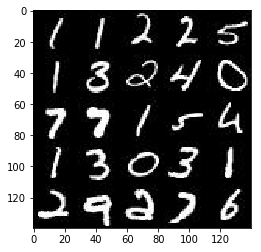

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

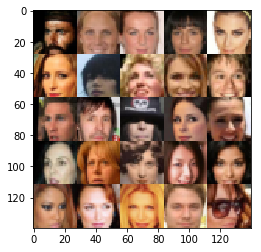

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    #stddev = 0.02
    with tf.variable_scope('discriminator', reuse = reuse):
        # Conv Layer - 28 x 28 x depth -> 28 x 28 x 64
        conv_1 = tf.layers.conv2d(images, 64, 3, strides = 1, padding = 'same')
        conv_1 = tf.maximum(conv_1, conv_1 * alpha)
        # Conv Layer - 28 x 28 x 64 -> 14 x 14 x 64
        conv_2 = tf.layers.conv2d(conv_1, 64, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_2 = tf.layers.batch_normalization(conv_2, training = True)
        conv_2 = tf.maximum(conv_2, conv_2 * alpha)
        # Conv Layer - 14 x 14 x 64 -> 14 x 14 x 128
        conv_3 = tf.layers.conv2d(conv_2, 128, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_3 = tf.layers.batch_normalization(conv_3, training = True)
        conv_3 = tf.maximum(conv_3, conv_3 * alpha)
        # Conv Layer - 14 x 14 x 128 -> 7 x 7 x 128
        conv_4 = tf.layers.conv2d(conv_3, 128, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_4 = tf.layers.batch_normalization(conv_4, training = True)
        conv_4 = tf.maximum(conv_4, conv_4 * alpha)
        # Conv Layer - 7 x 7 x 128 -> 7 x 7 x 256
        conv_5 = tf.layers.conv2d(conv_4, 256, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_5 = tf.layers.batch_normalization(conv_5, training = True)
        conv_5 = tf.maximum(conv_5, conv_5 * alpha)
        # Conv Layer - 7 X 7 X 256 -> 4 x 4 x 512
        conv_6 = tf.layers.conv2d(conv_5, 512, 3, strides = 2, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_6 = tf.layers.batch_normalization(conv_6, training = True)
        conv_6 = tf.maximum(conv_6, conv_6 * alpha)
        # Flatten Layer - 4 x 4 x 512 -> 1 x 4 * 4 * 512
        flat = tf.reshape(conv_6, (-1, 4 * 4 * 512))
        # Fully Connected Layer - 1 x 4 * 4 * 512 -> 1
        logits = tf.layers.dropout(tf.layers.dense(flat, 1))
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    #stddev = 0.02
    with tf.variable_scope('generator', reuse = not is_train):
        # Dense Layer - size(z) ->  7 x 7 x 1024
        dense = tf.layers.dense(z, 7 * 7 * 1024)
        input_to_conv = tf.reshape(dense, (-1, 7, 7, 1024))
        input_to_conv = tf.layers.batch_normalization(input_to_conv, training = is_train)
        input_to_conv = tf.nn.relu(input_to_conv)
        # Conv Layer - 7 x 7 x 1024 -> 7 x 7 x 512
        conv_1 = tf.layers.conv2d(input_to_conv, 512, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_1 = tf.layers.batch_normalization(conv_1, training = is_train)
        conv_1 = tf.nn.relu(conv_1)
        # Deconv Layer - 7 x 7 x 512 -> 14 x 14 x 512
        conv_2 = tf.layers.conv2d_transpose(conv_1, 512, 3, strides = 2, padding = 'same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                            bias_initializer=tf.constant_initializer(0.0))
        conv_2 = tf.layers.batch_normalization(conv_2, training = is_train)
        conv_2 = tf.nn.relu(conv_2)
        # Conv Layer - 14 x 14 x 512 -> 14 x 14 x 256
        conv_3 = tf.layers.conv2d(conv_2, 256, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_3 = tf.layers.batch_normalization(conv_3, training = is_train)
        conv_3 = tf.nn.relu(conv_3)
        # Deconv Layer - 14 x 14 x 256 -> 28 x 28 x 256
        conv_4 = tf.layers.conv2d_transpose(conv_3, 256, 3, strides = 2, padding = 'same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                            bias_initializer=tf.constant_initializer(0.0))
        conv_4 = tf.layers.batch_normalization(conv_4, training = is_train)
        conv_4 = tf.nn.relu(conv_4)
        # Conv Layer - 28 x 28 x 256 -> 28 x 28 x 128
        conv_5 = tf.layers.conv2d(conv_4, 128, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_5 = tf.layers.batch_normalization(conv_5, training = is_train)
        conv_5 = tf.nn.relu(conv_5)
        # Conv Layer - 28 x 28 x 128 -> 28 x 28 x 64
        conv_6 = tf.layers.conv2d(conv_5, 64, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_6 = tf.layers.batch_normalization(conv_6, training = is_train)
        conv_6 = tf.nn.relu(conv_6)
        # Conv Layer - 28 x 28 x 128 -> 28 x 28 x 32
        conv_7 = tf.layers.conv2d(conv_6, 32, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_7 = tf.layers.batch_normalization(conv_7, training = is_train)
        conv_7 = tf.nn.relu(conv_7)
        # Conv Layer - 28 x 28 x 32 -> 28 x 28 x 16
        conv_8 = tf.layers.conv2d(conv_7, 16, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        conv_8 = tf.layers.batch_normalization(conv_8, training = is_train)
        conv_8 = tf.nn.relu(conv_8)
        # Conv Layer - 28 x 28 x 16 -> 28 x 28 x out_channel_dim
        conv_9 = tf.layers.conv2d(conv_8, out_channel_dim, 3, strides = 1, padding = 'same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                  bias_initializer=tf.constant_initializer(0.0))
        out = tf.tanh(conv_9)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                         labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                    labels = tf.ones_like(d_model_fake)* (1 - smooth)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                # TODO: Train Model
                steps += 1
                
                # Create random noise for the generator's input
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {inputs_real: batch_images, 
                                                            inputs_z: batch_z, 
                                                            lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {inputs_z: batch_z, 
                                                           inputs_real: batch_images, 
                                                           lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict = {inputs_z: batch_z, 
                                                           inputs_real: batch_images, 
                                                           lr: learning_rate})
                
                # Print losses
                if steps % 10 == 0:
                    # Evaluate losses and print them
                    train_loss_d = d_loss.eval({inputs_z: batch_z, 
                                                    inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Display generated images
                    if steps % 100 == 0:
                        show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
        print('Training Finished!')
                    
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.4071... Generator Loss: 3.9566
Epoch 1/3... Discriminator Loss: 0.4026... Generator Loss: 9.1191
Epoch 1/3... Discriminator Loss: 0.4629... Generator Loss: 2.6208
Epoch 1/3... Discriminator Loss: 1.0624... Generator Loss: 0.8130
Epoch 1/3... Discriminator Loss: 3.7860... Generator Loss: 0.3746
Epoch 1/3... Discriminator Loss: 2.3975... Generator Loss: 0.3748
Epoch 1/3... Discriminator Loss: 3.0750... Generator Loss: 0.3399
Epoch 1/3... Discriminator Loss: 2.6862... Generator Loss: 0.3396
Epoch 1/3... Discriminator Loss: 2.4662... Generator Loss: 0.3493
Epoch 1/3... Discriminator Loss: 2.6947... Generator Loss: 0.3322


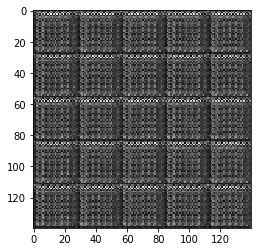

Epoch 1/3... Discriminator Loss: 2.3892... Generator Loss: 0.3400
Epoch 1/3... Discriminator Loss: 2.4034... Generator Loss: 0.3457
Epoch 1/3... Discriminator Loss: 2.0971... Generator Loss: 0.3668
Epoch 1/3... Discriminator Loss: 1.9210... Generator Loss: 0.4157
Epoch 1/3... Discriminator Loss: 1.8046... Generator Loss: 0.4179
Epoch 1/3... Discriminator Loss: 1.9066... Generator Loss: 0.4011
Epoch 1/3... Discriminator Loss: 1.7448... Generator Loss: 0.4709
Epoch 1/3... Discriminator Loss: 2.2200... Generator Loss: 0.3521
Epoch 1/3... Discriminator Loss: 1.8966... Generator Loss: 0.4068
Epoch 1/3... Discriminator Loss: 1.9917... Generator Loss: 0.3819


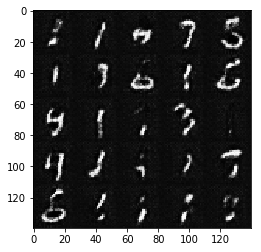

Epoch 1/3... Discriminator Loss: 2.0402... Generator Loss: 0.3699
Epoch 1/3... Discriminator Loss: 2.0204... Generator Loss: 0.3794
Epoch 1/3... Discriminator Loss: 1.9198... Generator Loss: 0.3910
Epoch 1/3... Discriminator Loss: 1.9223... Generator Loss: 0.3903
Epoch 1/3... Discriminator Loss: 1.9458... Generator Loss: 0.4116
Epoch 1/3... Discriminator Loss: 1.9716... Generator Loss: 0.3852
Epoch 1/3... Discriminator Loss: 1.8833... Generator Loss: 0.4115
Epoch 1/3... Discriminator Loss: 1.8676... Generator Loss: 0.4097
Epoch 1/3... Discriminator Loss: 1.9686... Generator Loss: 0.3815
Epoch 1/3... Discriminator Loss: 1.7944... Generator Loss: 0.4413


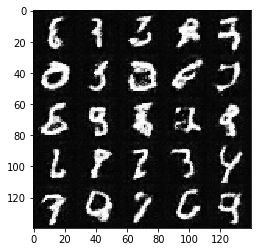

Epoch 1/3... Discriminator Loss: 1.9340... Generator Loss: 0.3940
Epoch 1/3... Discriminator Loss: 1.8519... Generator Loss: 0.4130
Epoch 1/3... Discriminator Loss: 1.7208... Generator Loss: 0.5217
Epoch 1/3... Discriminator Loss: 1.9480... Generator Loss: 1.2737
Epoch 1/3... Discriminator Loss: 1.5767... Generator Loss: 0.6258
Epoch 1/3... Discriminator Loss: 1.4903... Generator Loss: 0.8705
Epoch 1/3... Discriminator Loss: 1.5482... Generator Loss: 0.7150
Epoch 1/3... Discriminator Loss: 1.6615... Generator Loss: 0.6666
Epoch 1/3... Discriminator Loss: 1.6958... Generator Loss: 0.5456
Epoch 1/3... Discriminator Loss: 2.0101... Generator Loss: 0.3763


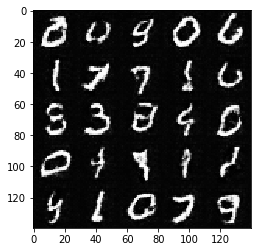

Epoch 1/3... Discriminator Loss: 1.8224... Generator Loss: 0.4172
Epoch 1/3... Discriminator Loss: 1.7855... Generator Loss: 0.4339
Epoch 1/3... Discriminator Loss: 1.8376... Generator Loss: 0.4188
Epoch 1/3... Discriminator Loss: 1.7266... Generator Loss: 0.4745
Epoch 1/3... Discriminator Loss: 1.9759... Generator Loss: 0.3903
Epoch 1/3... Discriminator Loss: 1.6658... Generator Loss: 0.4788
Epoch 2/3... Discriminator Loss: 1.7320... Generator Loss: 0.4663
Epoch 2/3... Discriminator Loss: 1.8204... Generator Loss: 0.4195
Epoch 2/3... Discriminator Loss: 1.7491... Generator Loss: 0.4406
Epoch 2/3... Discriminator Loss: 1.7862... Generator Loss: 0.4297


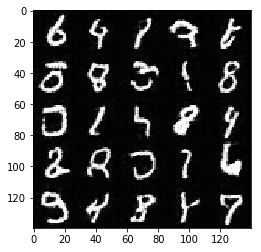

Epoch 2/3... Discriminator Loss: 1.8063... Generator Loss: 0.4272
Epoch 2/3... Discriminator Loss: 2.3226... Generator Loss: 0.3480
Epoch 2/3... Discriminator Loss: 1.6411... Generator Loss: 0.5233
Epoch 2/3... Discriminator Loss: 1.6341... Generator Loss: 0.6133
Epoch 2/3... Discriminator Loss: 1.6201... Generator Loss: 0.9409
Epoch 2/3... Discriminator Loss: 1.6481... Generator Loss: 0.5178
Epoch 2/3... Discriminator Loss: 1.5761... Generator Loss: 0.5619
Epoch 2/3... Discriminator Loss: 1.6624... Generator Loss: 0.9448
Epoch 2/3... Discriminator Loss: 1.5627... Generator Loss: 0.5956
Epoch 2/3... Discriminator Loss: 1.5860... Generator Loss: 0.6120


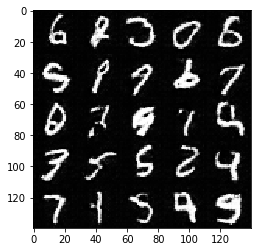

Epoch 2/3... Discriminator Loss: 2.4601... Generator Loss: 0.3375
Epoch 2/3... Discriminator Loss: 1.6165... Generator Loss: 0.5599
Epoch 2/3... Discriminator Loss: 1.6539... Generator Loss: 0.5098
Epoch 2/3... Discriminator Loss: 1.6345... Generator Loss: 0.5617
Epoch 2/3... Discriminator Loss: 1.8636... Generator Loss: 0.4088
Epoch 2/3... Discriminator Loss: 1.7583... Generator Loss: 0.4533
Epoch 2/3... Discriminator Loss: 1.6306... Generator Loss: 0.5293
Epoch 2/3... Discriminator Loss: 1.5251... Generator Loss: 0.6869
Epoch 2/3... Discriminator Loss: 1.7562... Generator Loss: 1.0151
Epoch 2/3... Discriminator Loss: 1.5644... Generator Loss: 0.8595


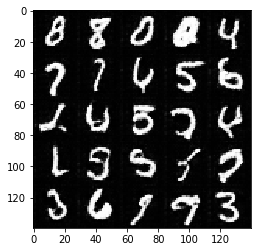

Epoch 2/3... Discriminator Loss: 1.5144... Generator Loss: 0.6516
Epoch 2/3... Discriminator Loss: 1.5429... Generator Loss: 0.7232
Epoch 2/3... Discriminator Loss: 1.5383... Generator Loss: 0.7183
Epoch 2/3... Discriminator Loss: 1.7062... Generator Loss: 1.0132
Epoch 2/3... Discriminator Loss: 1.5720... Generator Loss: 0.5980
Epoch 2/3... Discriminator Loss: 1.7444... Generator Loss: 0.9013
Epoch 2/3... Discriminator Loss: 1.6159... Generator Loss: 0.6386
Epoch 2/3... Discriminator Loss: 1.5380... Generator Loss: 0.6542
Epoch 2/3... Discriminator Loss: 1.4904... Generator Loss: 0.6897
Epoch 2/3... Discriminator Loss: 1.5550... Generator Loss: 0.6735


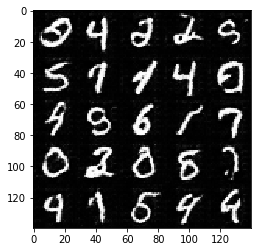

Epoch 2/3... Discriminator Loss: 1.5747... Generator Loss: 0.7124
Epoch 2/3... Discriminator Loss: 1.5972... Generator Loss: 0.6535
Epoch 2/3... Discriminator Loss: 1.5773... Generator Loss: 0.6331
Epoch 2/3... Discriminator Loss: 1.5513... Generator Loss: 0.5523
Epoch 2/3... Discriminator Loss: 1.6668... Generator Loss: 0.4818
Epoch 2/3... Discriminator Loss: 1.6702... Generator Loss: 0.5061
Epoch 2/3... Discriminator Loss: 1.6365... Generator Loss: 0.5118
Epoch 2/3... Discriminator Loss: 1.6136... Generator Loss: 0.6024
Epoch 2/3... Discriminator Loss: 1.6220... Generator Loss: 0.5551
Epoch 2/3... Discriminator Loss: 1.7315... Generator Loss: 0.4537


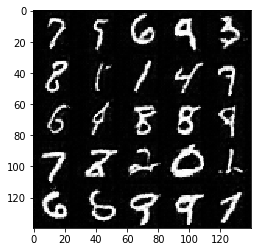

Epoch 2/3... Discriminator Loss: 1.4932... Generator Loss: 0.6584
Epoch 2/3... Discriminator Loss: 1.8721... Generator Loss: 0.4028
Epoch 2/3... Discriminator Loss: 1.5898... Generator Loss: 0.5748
Epoch 3/3... Discriminator Loss: 1.5485... Generator Loss: 0.5515
Epoch 3/3... Discriminator Loss: 1.5708... Generator Loss: 0.6028
Epoch 3/3... Discriminator Loss: 1.7601... Generator Loss: 0.4483
Epoch 3/3... Discriminator Loss: 1.7197... Generator Loss: 0.4479
Epoch 3/3... Discriminator Loss: 1.5277... Generator Loss: 0.5876
Epoch 3/3... Discriminator Loss: 1.7823... Generator Loss: 0.4320
Epoch 3/3... Discriminator Loss: 1.5910... Generator Loss: 0.5694


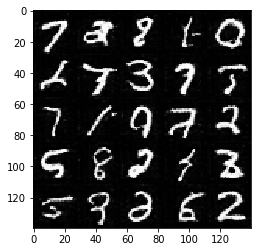

Epoch 3/3... Discriminator Loss: 1.5356... Generator Loss: 0.6107
Epoch 3/3... Discriminator Loss: 1.8175... Generator Loss: 0.4188
Epoch 3/3... Discriminator Loss: 1.7064... Generator Loss: 0.4625
Epoch 3/3... Discriminator Loss: 1.5226... Generator Loss: 0.6357
Epoch 3/3... Discriminator Loss: 1.6129... Generator Loss: 0.6195
Epoch 3/3... Discriminator Loss: 1.5216... Generator Loss: 0.6427
Epoch 3/3... Discriminator Loss: 1.5390... Generator Loss: 0.6668
Epoch 3/3... Discriminator Loss: 1.5989... Generator Loss: 0.5747
Epoch 3/3... Discriminator Loss: 1.8104... Generator Loss: 0.4237
Epoch 3/3... Discriminator Loss: 1.5342... Generator Loss: 0.8250


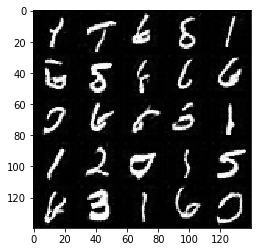

Epoch 3/3... Discriminator Loss: 1.6460... Generator Loss: 0.4902
Epoch 3/3... Discriminator Loss: 1.6043... Generator Loss: 0.5552
Epoch 3/3... Discriminator Loss: 1.6025... Generator Loss: 0.6878
Epoch 3/3... Discriminator Loss: 1.5181... Generator Loss: 0.6952
Epoch 3/3... Discriminator Loss: 1.5735... Generator Loss: 0.6834
Epoch 3/3... Discriminator Loss: 1.6661... Generator Loss: 0.5039
Epoch 3/3... Discriminator Loss: 1.5890... Generator Loss: 0.5742
Epoch 3/3... Discriminator Loss: 1.6062... Generator Loss: 0.8675
Epoch 3/3... Discriminator Loss: 1.5085... Generator Loss: 0.7246
Epoch 3/3... Discriminator Loss: 1.6307... Generator Loss: 0.6341


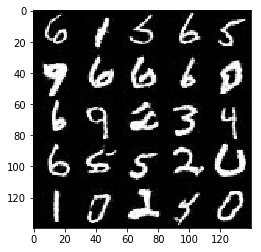

Epoch 3/3... Discriminator Loss: 1.5041... Generator Loss: 0.5775
Epoch 3/3... Discriminator Loss: 1.5169... Generator Loss: 0.6265
Epoch 3/3... Discriminator Loss: 1.7468... Generator Loss: 0.4625
Epoch 3/3... Discriminator Loss: 1.5936... Generator Loss: 0.5256
Epoch 3/3... Discriminator Loss: 1.4615... Generator Loss: 0.8205
Epoch 3/3... Discriminator Loss: 1.5294... Generator Loss: 0.6659
Epoch 3/3... Discriminator Loss: 1.5129... Generator Loss: 0.7749
Epoch 3/3... Discriminator Loss: 1.6689... Generator Loss: 0.4986
Epoch 3/3... Discriminator Loss: 1.6386... Generator Loss: 0.5274
Epoch 3/3... Discriminator Loss: 1.6236... Generator Loss: 0.4955


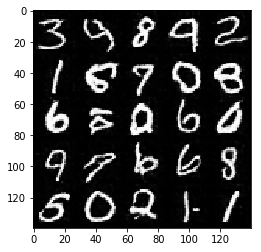

Epoch 3/3... Discriminator Loss: 1.7179... Generator Loss: 0.4599
Epoch 3/3... Discriminator Loss: 1.5725... Generator Loss: 0.6083
Epoch 3/3... Discriminator Loss: 1.5365... Generator Loss: 0.6708
Epoch 3/3... Discriminator Loss: 1.5143... Generator Loss: 0.7730
Epoch 3/3... Discriminator Loss: 1.5332... Generator Loss: 0.7430
Epoch 3/3... Discriminator Loss: 1.4569... Generator Loss: 0.6166
Epoch 3/3... Discriminator Loss: 1.6027... Generator Loss: 0.9837
Epoch 3/3... Discriminator Loss: 1.6276... Generator Loss: 0.6327
Epoch 3/3... Discriminator Loss: 1.5919... Generator Loss: 0.7757
Epoch 3/3... Discriminator Loss: 1.5514... Generator Loss: 0.6474


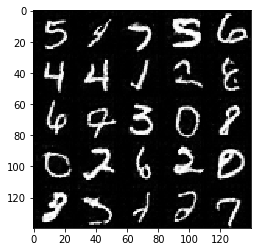

Training Finished!


In [14]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 4.8845... Generator Loss: 0.4593
Epoch 1/2... Discriminator Loss: 3.4599... Generator Loss: 0.3489
Epoch 1/2... Discriminator Loss: 2.7460... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 3.7904... Generator Loss: 2.6041
Epoch 1/2... Discriminator Loss: 2.9624... Generator Loss: 1.2847
Epoch 1/2... Discriminator Loss: 2.6697... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 2.1106... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.7960... Generator Loss: 1.4326
Epoch 1/2... Discriminator Loss: 1.4254... Generator Loss: 1.6494
Epoch 1/2... Discriminator Loss: 2.3600... Generator Loss: 0.3784


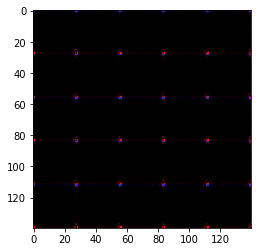

Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 1.8426... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.6961... Generator Loss: 0.5458
Epoch 1/2... Discriminator Loss: 1.8124... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 2.0632... Generator Loss: 0.3681
Epoch 1/2... Discriminator Loss: 1.7603... Generator Loss: 1.4761
Epoch 1/2... Discriminator Loss: 1.5994... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 1.0439


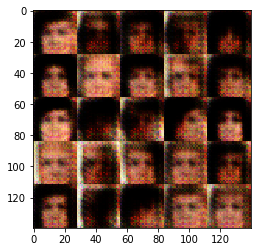

Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.9006... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.9577... Generator Loss: 0.4079
Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 1.7968... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.7465... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 1.7406... Generator Loss: 0.4356


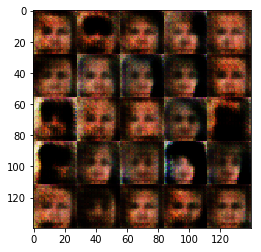

Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.7824... Generator Loss: 0.4619
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.9395... Generator Loss: 0.3959
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.7124... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 1.7232... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 1.6331... Generator Loss: 0.4807
Epoch 1/2... Discriminator Loss: 1.7234... Generator Loss: 0.4870


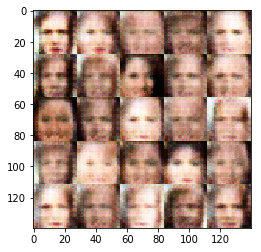

Epoch 1/2... Discriminator Loss: 1.7011... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 1.1385
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.8760


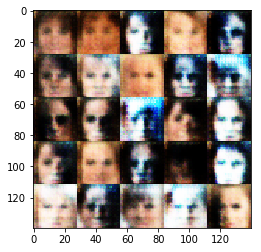

Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.6018... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.8418


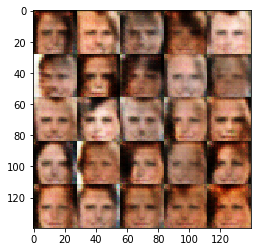

Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.7507... Generator Loss: 0.4773
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.5987


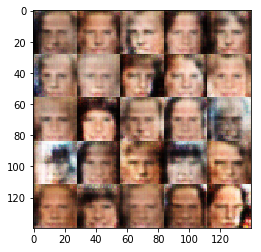

Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.5749
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.5435


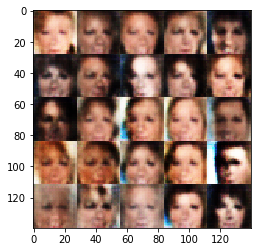

Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.7016... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.6065... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.7791


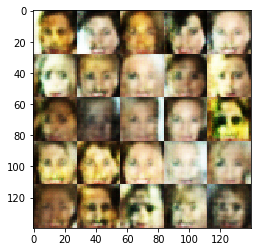

Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 0.5799
Epoch 1/2... Discriminator Loss: 1.6895... Generator Loss: 0.5094


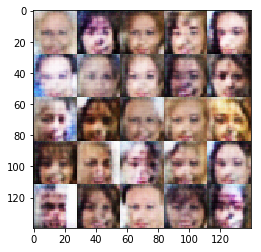

Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.5529
Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.6604


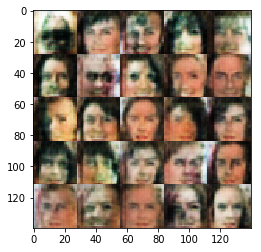

Epoch 1/2... Discriminator Loss: 1.6262... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.5763
Epoch 1/2... Discriminator Loss: 1.6164... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 0.5777
Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.5900... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.6241... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.6619... Generator Loss: 0.5512


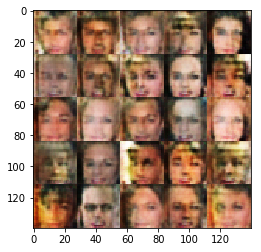

Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.5703
Epoch 1/2... Discriminator Loss: 1.5558... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.6083... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.6352


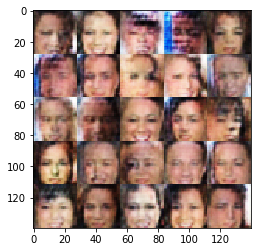

Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.5795... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.6539


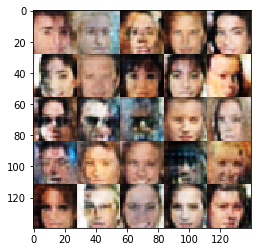

Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.5773... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.6468


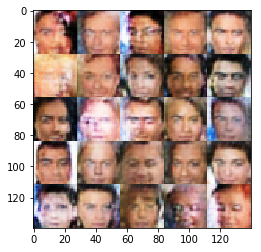

Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.6163
Epoch 1/2... Discriminator Loss: 1.5164... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.5149... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.5479... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.5100... Generator Loss: 0.6452


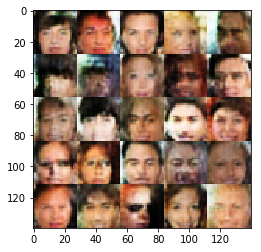

Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.6271
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 0.6451
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.5098... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.6855


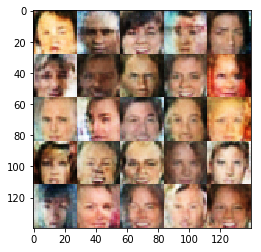

Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 1.5024... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.4699... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.6939


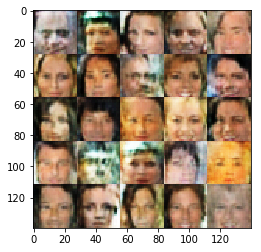

Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.4803... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.4843... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.5129... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.4825... Generator Loss: 0.8009


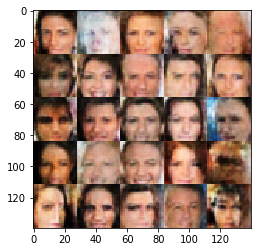

Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.4888... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.4706... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.5041... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.7622


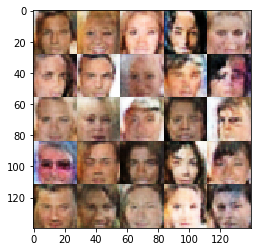

Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.4697... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.7259


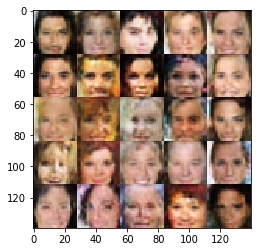

Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.7005
Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.6713


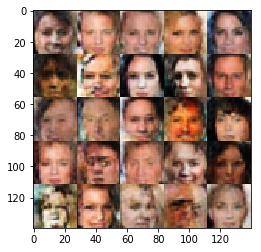

Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.4605... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.6391


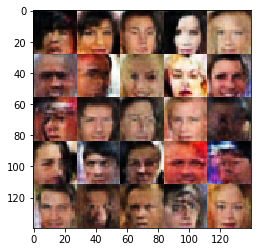

Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 0.7618


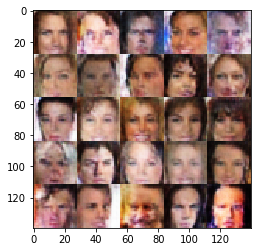

Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.7320


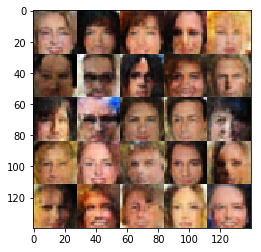

Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.4628... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.4888... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 0.7837


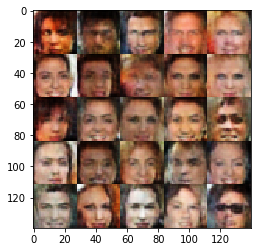

Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.6998
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.8239


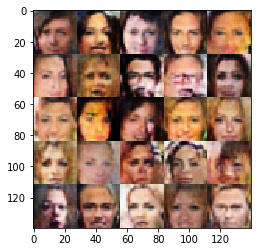

Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.8434


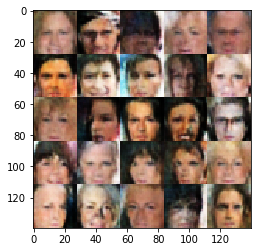

Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.4472... Generator Loss: 0.8816


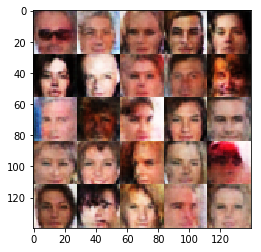

Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.7560


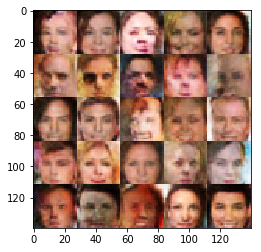

Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.7566


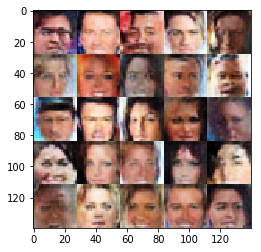

Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.8245
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.7390
Training Finished!


In [12]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.